In [1]:
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ydata_profiling
import seaborn as sns
import warnings

from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV

%matplotlib inline

C:\Users\lebeda\anaconda3\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\lebeda\anaconda3\Lib\site-packages\visions\backends\shared\nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit


In [2]:
warnings.simplefilter('ignore')#отключение предупреждений

# Постановка задачи и описание исследуемого технологического процесса

## Постановка задачи

Для металлургического комбината с целью оптимизации производственных расходов (посредством уменьшения потребления электроэнергии на этапе обработки стали) необходимо построить модель предсказания температуры стали.

## Описание технологического процесса

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед тем, как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

После этого расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

Схематично исследумый технологический процесс можно представить следующим образом:
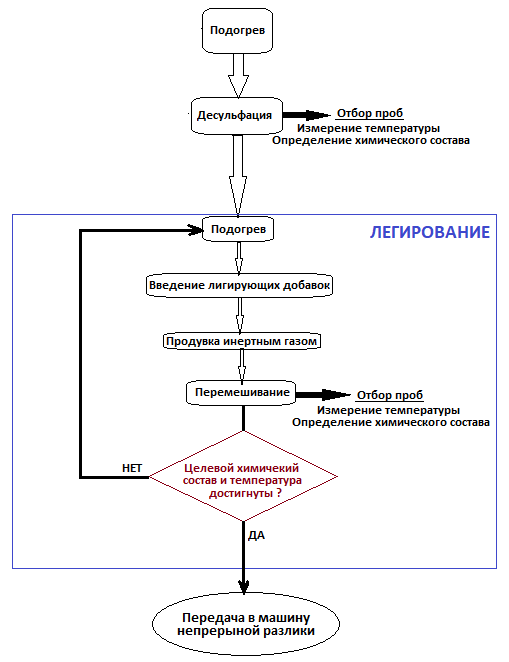

# Загрузка и предварительный анализ данных

## Загрузка данных

Проведем загрузку предоставленного набора данных о технологических параметрах и операуиях при подготовке рассплава к разливке.

In [3]:
data_arc = pd.read_csv(r'C:\Users\lebeda\Yandex_Practicum\Yandex_projects\data_sets\prjkt_15(sp21)\data_arc.csv')
data_bulk = pd.read_csv(r'C:\Users\lebeda\Yandex_Practicum\Yandex_projects\data_sets\prjkt_15(sp21)\data_bulk.csv')
data_bulk_time = pd.read_csv(r'C:\Users\lebeda\Yandex_Practicum\Yandex_projects\data_sets\prjkt_15(sp21)\data_bulk_time.csv')
data_gas = pd.read_csv(r'C:\Users\lebeda\Yandex_Practicum\Yandex_projects\data_sets\prjkt_15(sp21)\data_gas.csv')
data_temp = pd.read_csv(r'C:\Users\lebeda\Yandex_Practicum\Yandex_projects\data_sets\prjkt_15(sp21)\data_temp.csv')
data_wire = pd.read_csv(r'C:\Users\lebeda\Yandex_Practicum\Yandex_projects\data_sets\prjkt_15(sp21)\data_wire.csv')
data_wire_time = pd.read_csv(r'C:\Users\lebeda\Yandex_Practicum\Yandex_projects\data_sets\prjkt_15(sp21)\data_wire_time.csv')

Согласно предложенному описанию данные содержат:

- `data_arc` — данные об электродах;
- `data_bulk` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time` — данные о подаче сыпучих материалов (время);
- `data_gas` — данные о продувке сплава газом;
- `data_temp` — результаты измерения температуры;
- `data_wire` — данные о проволочных материалах (объём);
- `data_wire_time` — данные о проволочных материалах (время).

Во всех файлах столбец 'key' содержит номер партии. В файлах может быть несколько строк с одинаковым значением 'key', они соответствуют разным итерациям обработки.

## Анализ данных

Проведем предварительный анализ данных: установим их состав, тип, особенности, аномалии, адекватность.

In [4]:
def inspection(data): #функция первичного ознакомления с данными
    print(data.head())
    print()
    print('Размерность:', data.shape)
    print()
    print('Общая информация о данных')
    print()
    print(data.info())
    print()
    print('Описательные статистики')
    print(data.describe())
    print()
    print('Количество пропусков')
    print(data.isna().sum())
    print()
    print('Количество полных дубликатов:', data.duplicated().sum())
    print()
    print('Колличество уникальных значений номеров описанных партий:', data.key.nunique())

### Исследование данных об электродах.

In [5]:
#data_arc.profile_report().to_notebook_iframe()

In [6]:
inspection(data_arc)

   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397  

Размерность: (14876, 5)

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Ак

<Axes: >

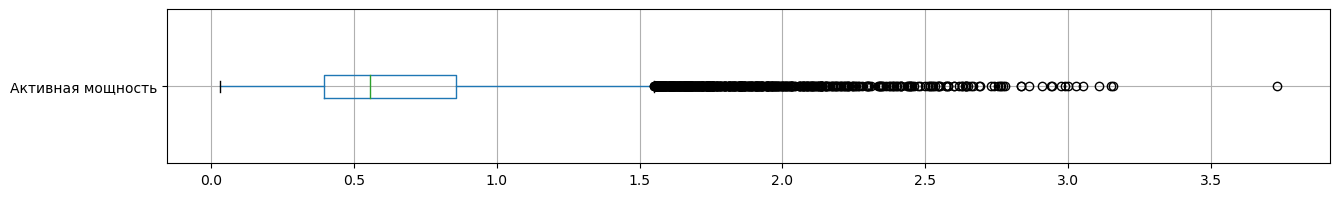

In [7]:
data_arc.boxplot(column=['Активная мощность'], vert=False, figsize=(15,2))

<Axes: >

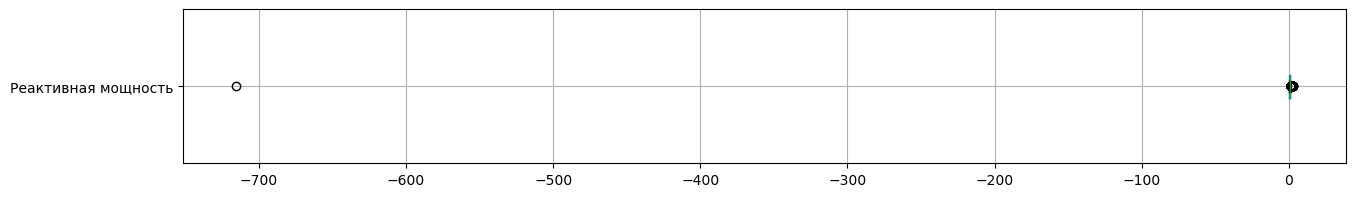

In [8]:
data_arc.boxplot(column=['Реактивная мощность'], vert=False, figsize=(15,2))

Таблица с данными об электродах data_arc содержит 5 столбцов и 14876 строк.

Столбцы включают в себя следующую информацию:
 - key - номер партии;
 - Начало нагрева дугой;
 - Конец нагрева дугой;
 - Активная мощность (единицы измерений не приведены (предположительно МВт));
 - Реактивная мощность (единицы измерений не приведены (предположительно Мвар)).
 
 Столбцы со значениями начала и окончания периодов нагрева дугой представляют из себя категориальные признаки(дата), остальные - числовые (как int, так и float).
 
 Пропуски и дубликаты значений отсутсвуют.
 
 В таблице притсутствует 3214 уникальных номеров описанных партий плавок металла.
 
 Данные по активной мощности смещены вправо, присутсвует определенный набор значений, выбивающийся за границы установленных нормальных значений. Однако опровергнуть их подлинность невозможно. 
 
 Данные по реактивной мощности также смещены вправо, наблюдается отчетливый выброс с величиной -715.5049242 -, скорее всего являющийся (с учетом значения и знака) ошибкой записи или самого измерения.
 
 Наблюдается высокий коэффициент корреляции значений активной и реактивной мощности.

### Исследование данных о результатах измерения температуры.

In [9]:
#data_temp.profile_report().to_notebook_iframe()

In [10]:
inspection(data_temp)

   key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0

Размерность: (15907, 3)

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

Описательные статистики
                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241

<Axes: >

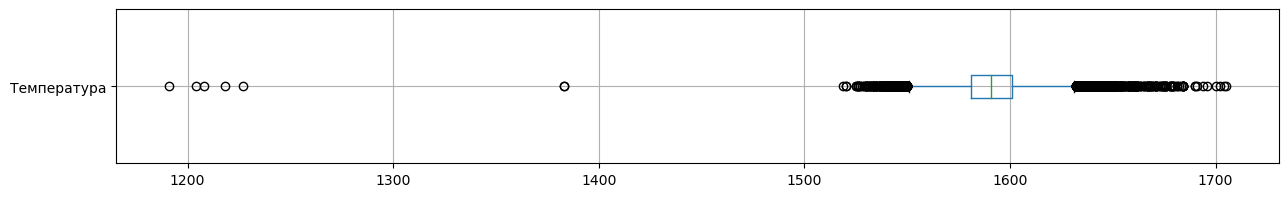

In [11]:
data_temp.boxplot(column=['Температура'], vert=False, figsize=(15,2))

Таблица с данными о результатах измерения температуры содержит 3 столбца и 15907 строк.
Столбцы включают в себя следующую информацию:
 - key - номер партии;
 - Время замера;
 - Температура (единицы измерений не приведены).
 
 Столбцы со значениями времени замера представляют из себя категориальные признаки(дата), остальные - числовые (как int, так и float).
 
 В таблице присутствует 2901 строка с пропусками значений температуры при фиксированном времени замера.
 
 Полные дубликаты строк отсутсвуют. 
 
 В таблице притсутствует 3216 уникальных номеров описанных партий плавок металла.
 
 Данные по значениям температуры распределены нормально. Большая часть значений в установленных нормальных пределах лежит примерно в диапазоне 1575 - 1600. В выбросах за границами нормальных значений наблюдаются отдельные скопления значений (фракции) в нескольких диапазонах (1200 - 1250, 1525-1550, 1625-1700).
 
 Следует отметить, что температура является целевым для прогозирования признаком, поэтому дальнейшее заполнение пропусков по этому параметру является нецелесообразным. Партии плавок, имеющие пропуски по температуре следует исключить из построения целевой модели прогнозирования.


### Исследование данных о подаче сыпучих материалов (объём).

In [12]:
#data_bulk.profile_report().to_notebook_iframe()

In [13]:
inspection(data_bulk)

   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  

Размерность: (3129, 16)

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):

<Axes: >

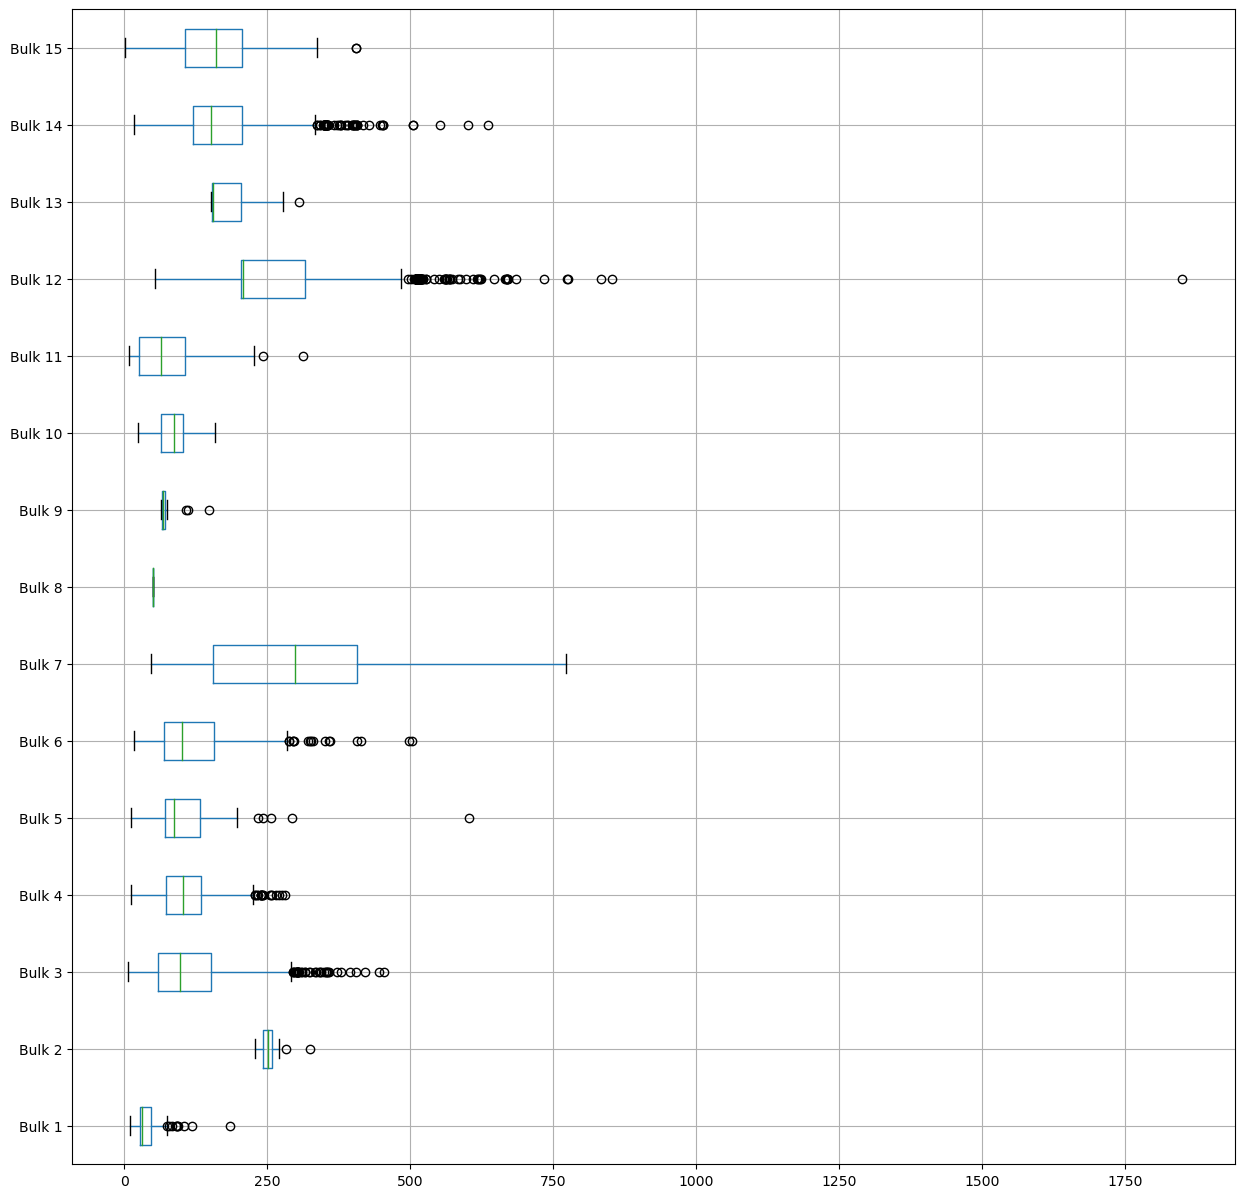

In [14]:
data_bulk.boxplot(column=['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10',
                          'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'], vert=False, figsize=(15,15))

Таблица с данными  о подаче сыпучих материалов (объём) содержит 16 столбцов и 3129 строк.
Столбцы включают в себя следующую информацию:
 - key - номер партии;
 - bulk - данные о объеме подачи сыпучих материалов: 15 выделенных столбцов (единицы измерений не приведены);
 
 
 Столбцы со значениями объемов добавок и номером партии - числовые данные(float и int).
 
 В таблице присутствует 35776 пропущенных значений в различных сочетаниях по столбцам bulk. Следует предположить, что пропуски значений в объемах сыпучих материалов - это отсутствие применения добавок в конкретном случае. Таким образом, целесообразно произвести замену отсутсвующих данных на нулевые значения.
 
 Полные дубликаты строк отсутсвуют. 
 
 В таблице присутствует 3129 уникальных номеров описанных партий плавок металла, что соответсвует колличеству строк, это означает, что каждая строка представляет собой данные по одной конкретной партии плавки. 
 
Данные по объемам добавок преимущественно смещены вправо, по столбцу Bulk 8 присутсвует только одно значение, отдельные столбцы имеют высокую степень корреляции (как прямой так и обратной) с другими столбцами. Согласно диаграмме размаха наибольшее значение имеет сыпучая добавка Bulk 7, как наиболее часто используемая.

### Исследование данных о подаче сыпучих материалов (время).

In [15]:
#data_bulk_time.profile_report().to_notebook_iframe()

In [16]:
inspection(data_bulk_time)

   key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  


Таблица с данными  о подаче сыпучих материалов (время) содержит 16 столбцов и 3129 строк.
Столбцы включают в себя следующую информацию:
 - key - номер партии;
 - bulk - данные о времени подачи сыпучих материалов: 15 выделенных столбцов;
 
 
 Столбцы со значениями времени ввода сыпучих добавок представляют из себя категориальные признаки(дата), объемы добавок - числовые данные(int).
 
 В таблице присутствует 35776 пропущенных значений в различных сочетаниях по столбцам bulk.
 
  
 Полные дубликаты строк отсутсвуют. 
 
 В таблице присутствует 3129 уникальных номеров описанных партий плавок металла, что соответсвует колличеству строк, что означает, что каждая строка - это данные по одной конкретной партии плавки. 
 
Если соотнести колличество пропусков по одельным столбцам с пропусками в  таблице объема добавок, можно заключить что  в месте пропусков в таблице объемов, добавки не вводились - время ввода добавок не зафиксировано.
 


### Исследование данных о  проволочных материалах (объём).

In [17]:
#data_wire.profile_report().to_notebook_iframe()

In [18]:
inspection(data_wire)

   key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  

Размерность: (3081, 10)

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6 

<Axes: >

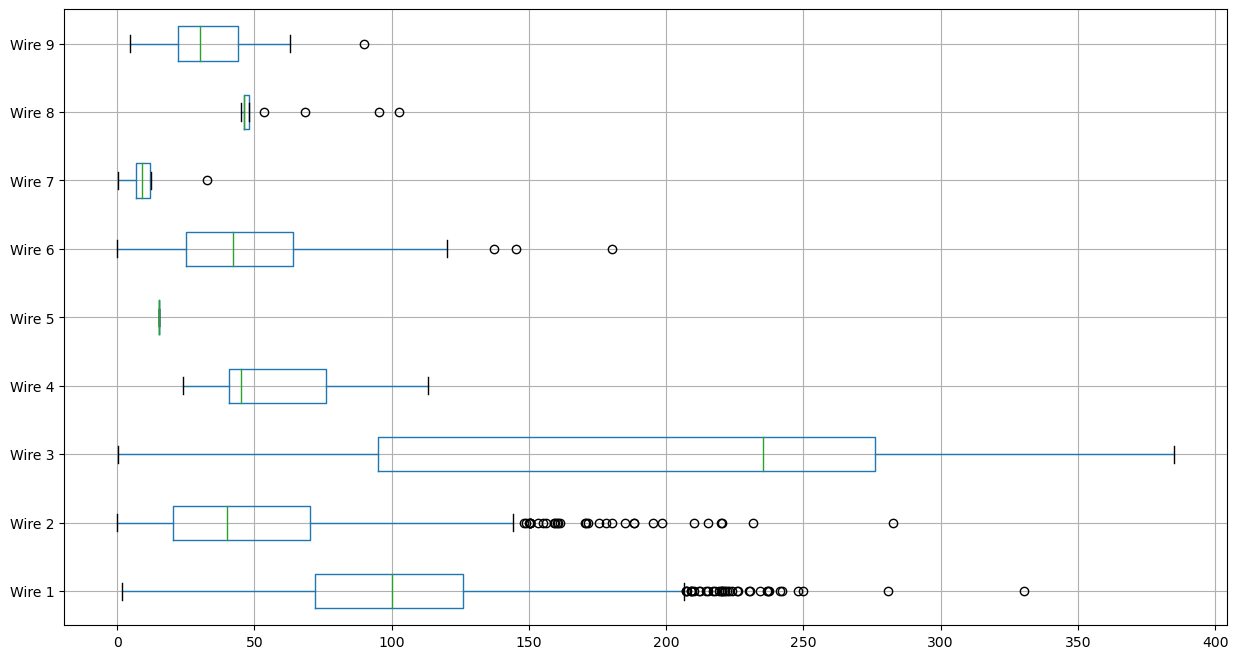

In [19]:
data_wire.boxplot(column=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'], 
                  vert=False, figsize=(15,8))

Таблица с данными  о подаче проволочных материалов (объём) содержит 10 столбцов и 3081 строк.
Столбцы включают в себя следующую информацию:
 - key - номер партии;
 - wire - данные о объеме подачи проволочных материалов: 9 выделенных столбцов (единицы измерений не приведены);
 
 
 Столбцы со значениями объемов добавок и номером партии - числовые данные(float и int).
 
 В таблице присутствует 23385 пропущенных значений в различных сочетаниях по столбцам wire.
 
 Полные дубликаты строк отсутсвуют. 
 
 В таблице присутствует 3081 уникальных номеров описанных партий плавок металла, что соответсвует колличеству строк, это означает, что каждая строка представляет собой данные по одной конкретной партии плавки.
 Аналогично сыпучим добавкам для проволочных материалов целесообразно произвести замену отсутсвующих данных на нулевые значения.
 
Данные по объемам добавок проволочных материалов имеют различный вид распределения, преимущественно смещены вправо, по столбцу Wire 5 присутсвует только одно значение, отдельные столбцы имеют высокую степень корреляции с другими столбцами. 

Согласно диаграмме размаха, наибольшее применение имеет проволочная добавка Wire 3.
 


### Исследование данных о  проволочных материалах (время).

In [20]:
#data_wire_time.profile_report().to_notebook_iframe()

In [21]:
inspection(data_wire_time)

   key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  

Размерность: (3081, 10)

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     

Таблица с данными  о подаче проволочных материалов (время) содержит 10 столбцов и 3081 строку.
Столбцы включают в себя следующую информацию:
 - key - номер партии;
 - Wire - данные о времени подачи проволочных материалов: 9 выделенных столбцов;
 
 
 Столбцы со значениями времени ввода проволочных материалов представляют из себя категориальные признаки(дата), объемы добавок - числовые данные(int).
 
 В таблице присутствует 23385 пропущенных значений в различных сочетаниях по столбцам Wire.
 
  
 Полные дубликаты строк отсутсвуют. 
 
 В таблице присутствует 3081 уникальный номер описанных партий плавок металла, что соответсвует колличеству строк, что означает, что каждая строка - это данные по одной конкретной партии плавки. 
 
Если соотнести колличество пропусков по одельным столбцам с пропусками в  таблице объема добавок проволочных материалов, можно заключить, что  в месте пропусков в таблице объемов, добавки не вводились - время ввода добавок не зафиксировано.
 


### Исследование данных о  продувке сплава газом.

In [22]:
#data_gas.profile_report().to_notebook_iframe()

In [23]:
inspection(data_gas)

   key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

Размерность: (3239, 2)

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

Описательные статистики
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

Количество пропусков
key      0
Газ 1    0
dtype: int64

Количество полных дубликатов: 0

Колличество уникальных значений номеров описанных партий: 3239


<Axes: >

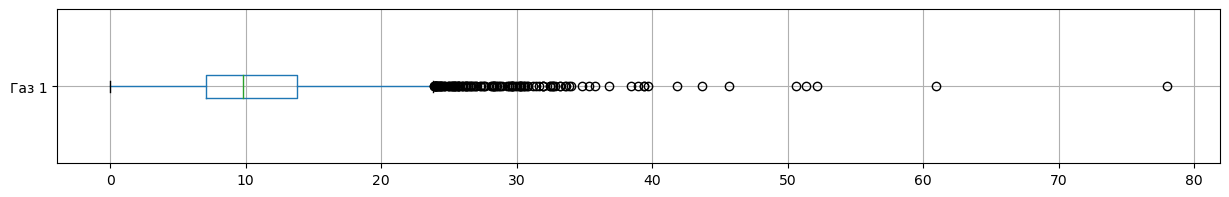

In [24]:
data_gas.boxplot(column=['Газ 1'], 
                  vert=False, figsize=(15,2))

Таблица с данными  о продувке сплава газом содержит 2 столбца и 3239 строк.
Столбцы включают в себя следующую информацию:
 - key - номер партии;
 - Газ 1 - данные об использовании газа (единицы измерений не приведены);
 
 
 Столбцы со значениями по газу и номером партии - числовые данные(float и int).
 
Пропуски и дубликаты значений отсутсвуют.

В таблице притсутствует 3239 уникальных номеров описанных партий плавок металла.

Данные по газу смещены вправо, присутсвует определенный набор значений, выбивающийся за границы установленных нормальных значений. Однако опровергнуть их подлинность невозможно.

Данные по реактивной мощности также смещены вправо.
Согласно диаграмме размаха диапазон нормальных значений лежит в пределах от 0 до примерно 25. Присутсвует весомый набор значний, выбивающийся за пределы нормальных значений справа.

### Выводы

Данные представленны 8 файлам, содержащими праметры технологических процессов подготовки металла к разливу с метками времени выполнения процессов:
- `data_arc` — данные о нагреве (5 столбцов и 14876 строк);
- `data_bulk` — данные о подаче сыпучих материалов (объём) (16 столбцов и 3129 строк);
- `data_bulk_time` — данные о подаче сыпучих материалов (время) (16 столбцов и 3129 строк);
- `data_gas` — данные о продувке сплава газом  (2 столбца и 3239 строк);
- `data_temp` — результаты измерения температуры (3 столбца и 15907 строк);
- `data_wire` — данные о проволочных материалах (объём) (10 столбцов и 3081 строк);
- `data_wire_time` — данные о проволочных материалах (время) (10 столбцов и 3081 строк).

Единицы измерения технологических параметров не приведены.

В исследуемой информации содержатся парметры о чуть более 3000 уникальных партий плавок металла.

Типы использемых данных: категориальные (метки времени), числовые (int и floаt - для указания номер партии и значений параметров технологических процессов).

Во всех таблицах, кроме данных о нагреве (data_arc) и продувке газом (data_gas), в различных сочетаниях присутсвую пропуски значений. Для таблиц, содержащих информацию о вводе лигирующих добавок (data_bulk, data_bulk_time, data_wire, data_wire_time) пропуски обусловлены отсутсвием ввода добавок в отдельные метки времени.

Полные дубликаты данных отсутсвую во всех таблицах.

По отдельнм данным наблюдаются выбросы за пределы границ нормальных значений. Для значений реактивной мощности наблюдаются аномально низкие величины, которые скорее всего являются ошибкой записи или измерения параметра.

Для ряда величин выявлены высокие коэффициенты корреляции (для активной и реактивной мощности, для объемов разного вида сыпучих и проволочных материалов).

В отличии от всех остальных, данные о продувке газом не дефференцированы по времени.

В данных о нагреве спалава электродами для периодов нагрева приведены константные значения мощностей.


# Предобработка данных

Приведем название столбцов всего предоставленно датасета к единому образцу.

## Переименование столбцов

In [25]:
data_arc = data_arc.rename(columns={'Начало нагрева дугой':'start_arc_heating',
                                    'Конец нагрева дугой':'finish_arc_heating',
                                    'Активная мощность':'p_pow',
                                    'Реактивная мощность':'q_pow'})

In [26]:
data_temp = data_temp.rename(columns={'Время замера':'measure_time', 'Температура':'temp'})

In [27]:
data_bulk = data_bulk.rename(columns=lambda col: col.lower().replace(" ", "_"))

In [28]:
data_bulk_time = data_bulk_time.rename(columns=lambda col: col.lower().replace(" ", "_") + '_t')
data_bulk_time = data_bulk_time.rename(columns={'key_t':'key'})

In [29]:
data_wire = data_wire.rename(columns=lambda col: col.lower().replace(" ", "_"))

In [30]:
data_wire_time = data_wire_time.rename(columns=lambda col: col.lower().replace(" ", "_") + '_t')
data_wire_time = data_wire_time.rename(columns={'key_t':'key'})

In [31]:
data_gas = data_gas.rename(columns={'Газ 1':'gas'})

## Изменение типов данных

Для корретного проведения анализа данных приведем отдельные столбцы, в частности, сдержащие метки времени к временному типу данных с заявленным форматом.

In [32]:
def to_date_format(data):
    return pd.to_datetime(data, format='%Y-%m-%d %H:%M:%S')

In [33]:
data_arc.start_arc_heating = to_date_format(data_arc.start_arc_heating)

In [34]:
data_arc.finish_arc_heating = to_date_format(data_arc.finish_arc_heating)

In [35]:
data_temp.measure_time = to_date_format(data_temp.measure_time)

In [36]:
for i in data_bulk_time.iloc[:, 1:]:
    data_bulk_time[i] = to_date_format(data_bulk_time[i])

In [37]:
for i in data_wire_time.iloc[:, 1:]:
    data_wire_time[i] = to_date_format(data_wire_time[i])

## Предобработка данных и  формирование признаков модели

Основной принцип формирования признаков модели будет заключаться в следующем: так как в качестве цели прогонозирования обозначена температура партии рассплава перед разливом, то в качестве целевого признака выберем последнюю по метке времени температуру для каждой конкретной партии. Для учета же влияния технологических факторов производства учтем все затраченные на этапе подготовки к разливу ресурсы: просуммируем объемы энергии, учтем объемы добавок (как сыпучих, так и проволочных), затраченных на протяжении всего технологического процесса, а также обратимся к пермому по хронологии значению температуры - будем считать его исходным состоянием. 

Из таблиц с технологическими параметрами (нагрев дугой, объемы добавок) отберем только те партии, по которым последний замер температуры является в приведенных данных последним по хронологии технологическим этапом, то есть условно, нужно рассматривать только полностью завершенные процессы подготовки металла, по которым присутсвует информация о выбранном целевом признаке.

На основании отобранных по обозначенными выше признакам ключей партии целевого признака проведем соединение таблиц таким образом, чтобы в итоговую таблицу попали только те партии, информация о которых присутсвует во всех таблицах.

### Обработка данных о технологических параметрах

#### Обработка data_temp

Определим перечень партий металла по которым имеются данные о значении температуры на конечном этапе подготовки металла.

In [38]:
#таблица с первыми замерами температуры в партиях - исходное состояние
first_temp_measuring = data_temp.groupby('key')['measure_time'].min().reset_index()

In [39]:
#таблица с последними замерами температуры в партиях
last_temp_measuring = data_temp.groupby('key')['measure_time'].max().reset_index()

Выделим из таблицы со значениями только те строки, в которых присутсвуют непустые значения температуры, а данные по метки времени являются последним замером.

In [40]:
data_last_temp_clear = data_temp.query('measure_time in @last_temp_measuring.measure_time and temp.notna()').reset_index(drop=True)
data_last_temp_clear = data_last_temp_clear.rename(columns={'temp':'last_temp', 'measure_time':'last_measure_time'})

Найдeм количество уникальных номеров партий, по которым есть данные о последнем замере температуры.

In [41]:
data_last_temp_clear.key.nunique()

2477

Аналогично проведем выборку первичных замеров температуры.

In [42]:
data_first_temp_clear = data_temp.query('measure_time in @first_temp_measuring.measure_time and temp.notna()').reset_index(drop=True)
data_first_temp_clear = data_first_temp_clear.rename(columns={'temp':'first_temp', 'measure_time':'first_measure_time'})

Проведем проверку для каждого номера полученной партии на предмет того, является ли последний приведенный замер последней технологической операцией подготовки металла, то есть является ли плавка партиии завершенной. Сравним полученное последнее время замера температуры с последними метками времени в других технологических процессах.

#### Обработка таблицы data_arc

Исключим из таблицы нагрева элетродами партии по которым имеются отрицательные значения мощностей.

In [43]:
data_arc.query('p_pow < 0 or q_pow < 0')

,key,start_arc_heating,finish_arc_heating,p_pow,q_pow
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [44]:
data_arc = data_arc.query('key != 2116').reset_index(drop=True)

In [45]:
data_arc.query('p_pow < 0 or q_pow < 0')

,key,start_arc_heating,finish_arc_heating,p_pow,q_pow


Для каждого периода нагрева проведем расчет полной энергии нагрева полученной за период времени как произведение полной мощности на время периода нагрева. Время периода нагрева переведем в часы, чтобы получить энергию в единицах системы СИ (МВА-ч, при условии что мощности приведены в МВт и Мвар соответсвенно).

In [46]:
#Продолжительность нагрева в часах
data_arc['arc_duration'] = (data_arc.finish_arc_heating - data_arc.start_arc_heating).astype('timedelta64[s]')/3600

In [47]:
data_arc['energy'] = np.sqrt(data_arc.p_pow**2 + data_arc.q_pow**2)*data_arc.arc_duration
data_arc.head()

,key,start_arc_heating,finish_arc_heating,p_pow,q_pow,arc_duration,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0.063333,0.075597
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.051389,0.049282
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.047778,0.042811
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0.101389,0.199784
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.041111,0.033186


Выделим из таблицы data_arc информацию только о тех партиях, по которым присутсвует значение температуры.

In [48]:
data_arc_clear = data_arc.query('key in @data_last_temp_clear.key').reset_index(drop=True)

In [49]:
#колличество уникальных номеров партий в таблице data_arc с учетом принятых данных по замерам температуры
data_arc_clear.key.nunique()

2474

Как видно из полученных данных, в таблице по нагреву элетродами не достает 2 номеров партий, данные по которым присутсвуют в таблице по замеру температур. Тат как данные по нагреву являются существенными, то для построения качественной модели уберем из целевого признака две недостающие по нагреву партии (вместо того, чтобы заполнять пропуски неизвестными или усредненными данными). Скорректируем таблицу по замеру температуры.

In [50]:
data_last_temp_clear = data_last_temp_clear.query('key in @data_arc_clear.key').reset_index(drop=True)
data_last_temp_clear.key.nunique()

2474

Для таблицы с данными о нагреве электродами проведем проверку наличия значений меток времени начала нагрева позднее времени окончания нагрева.

In [51]:
data_arc_clear.query('start_arc_heating > finish_arc_heating')

,key,start_arc_heating,finish_arc_heating,p_pow,q_pow,arc_duration,energy


Данные корректны, можно ориентироваться на значения меток времени с окончанием операций нагрева.
Выделим последние по хронологии метки времени с операцией нагрева электродами с учетом номеров партий полученных для данных замера температур.

In [52]:
last_finish_arc_heating = data_arc_clear.pivot_table(values = 'finish_arc_heating', index = 'key',
                                                     aggfunc = 'max').reset_index()

В таблице data_temp_clear выделим только те партии, в которых последний нагрев элетродами производился раньше замера температуры, то есть партии, которые можно считать технологически завершенными.

In [53]:
data_last_temp_clear = data_last_temp_clear.query('last_measure_time > @last_finish_arc_heating.finish_arc_heating').reset_index(drop=True)
data_last_temp_clear.key.nunique()

2343

Как видим число уникальных номеров партий сократилось.

Для постоения модели воспользуемся информацией о затраченной энергии на каждую уникальную партию металла. Сформируем таблицу для учета ее виде признаков прогонозирования (сгруппируем данные по партиям).

In [54]:
data_arc_energy_clear = data_arc_clear.pivot_table(values = ['arc_duration', 'energy'], index = 'key',
                                                   aggfunc = 'sum').reset_index()
data_arc_energy_clear.head()

,key,arc_duration,energy
0,1,0.305000,0.400660
1,2,0.225278,0.244787
2,3,0.181944,0.145852
3,4,0.205833,0.221364
4,5,0.241389,0.333094


#### Обработка таблицы data_bulk_time

Для начала проверим условие о содержание в таблицах data_bulk_time и data_bulk информации об одних и тех же партиях металла.

In [55]:
(data_bulk.key == data_bulk_time.key).unique()

array([ True])

Проверка подтвердила, что в таблицах со временем и объемами сыпучих добавок содержаться данные об одних и тех же партиях.

In [56]:
data_bulk_time.key.nunique() #колличество уникальных партий в таблице с временем внесения сыпучих добавок

3129

Извлечем из таблицы с временем добавок только те партии, по которым есть записи о последнем времени измерения температуры.

In [57]:
data_bulk_time_clear = data_bulk_time.query('key in @data_last_temp_clear.key').reset_index(drop=True)
data_bulk_time_clear.key.nunique()

2282

В таблице сданными о замерах температуры оставим только те партии, которые есть в полученной таблице с данными вводe сыпучих добавок. 

In [58]:
data_last_temp_clear = data_last_temp_clear.query('key in @data_bulk_time_clear.key').reset_index(drop=True)
data_last_temp_clear.key.nunique()

2282

Число партий дополнительно сократилось. 

В таблице с записями о времени ввода добавок для каждой партии найдем значение последней по времени записи.

In [59]:
#таблица с последними замерами температуры в партиях
data_bulk_time_clear['last_data_bulk_time'] = data_bulk_time_clear.iloc[:,1:].max(axis=1, skipna=True).reset_index(drop=True)

В таблице data_temp_clear выделим только те партии, в которых последняя добавка вводилась раньше замера температуры, то есть партии, которые можно считать технологически завершенными.

In [60]:
data_last_temp_clear = data_last_temp_clear.query('last_measure_time > @data_bulk_time_clear.last_data_bulk_time').reset_index(drop=True)
data_last_temp_clear.key.nunique()

2278

Как видим число уникальных номеров партий снова сократилось.

#### Обработка таблицы data_wire_time

Проверим условие о содержание в таблицах data_wire_time и data_wire информации об одних и тех же партиях металла.

In [61]:
(data_wire.key == data_wire_time.key).unique()

array([ True])

Проверка подтвердила, что в таблицах со временем и объемами добавок проволочных материалов содержаться данные об одних и тех же партиях.

In [62]:
data_wire_time.key.nunique() #колличество уникальных партий в таблице с временем внесения сыпучих добавок

3081

Извлечем из таблицы с временем добавок проволочных материалов только те партии, по которым есть записи о последнем времени измерения температуры.

In [63]:
data_wire_time_clear = data_wire_time.query('key in @data_last_temp_clear.key').reset_index(drop=True)
data_wire_time_clear.key.nunique()

2207

В таблице сданными о замерах температуры оставим только те партии, которые есть в полученной таблице с данными вводе проволочных материалов. 

In [64]:
data_last_temp_clear = data_last_temp_clear.query('key in @data_wire_time_clear.key').reset_index(drop=True)
data_last_temp_clear.key.nunique()

2207

Число партий сократилось. 

В таблице с записями о времени ввода добавок проволочных материалов для каждой партии найдем значение последней по времени записи.

In [65]:
#таблица с последними замерами температуры в партиях
data_wire_time_clear['last_data_wire_time'] = data_wire_time_clear.iloc[:,1:].max(axis=1, skipna=True).reset_index(drop=True)

В таблице data_temp_clear выделим только те партии, в которых последняя добавка вводилась раньше замера температуры, то есть партии, которые можно считать технологически завершенными.

In [66]:
data_last_temp_clear = data_last_temp_clear.query('last_measure_time > @data_wire_time_clear.last_data_wire_time').reset_index(drop=True)
data_last_temp_clear.key.nunique()

2207

Число уникальных номеров партий не изменилось.

#### Обработка таблицы data_bulk

In [67]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Предварительный осмотр таблицы data_bulk указал на то, что в данных с объемами сыпучих добавок присутсвует большое число пропусков, в то же время было установлено, что пропуски связаны с физическим отсутсвие (неприменением) добавок для конкретной партии (для них отсутсвует метка времени в таблице data_bulk_time). Кроме того, для одной из добавок количество применений составило всего 1 раз - bulk_8.


Удалим из перечня добавок столбец bulk_8.

Произведем замену пропусков на нулевые значения.

In [68]:
data_bulk_clear = data_bulk.drop('bulk_8', axis=1)

In [69]:
data_bulk_clear = data_bulk_clear.fillna(0)

#### Обработка таблицы data_wire

In [70]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Аналогичным образом предварительный осмотр таблицы data_wire указал на то, что в данных с объемами добавок проволочных материалов присутсвует большое число пропусков, в то же время было установлено, что пропуски связаны с физическим отсутсвие (неприменением) материалов для конкретной партии (отсутсвует метка времени в таблице data_wire_time). Кроме того, для одной из проволочных добавок количество применений составило всего 1 раз - wire_5.

Удалим из перечня добавок столбец wire_5.

Произведем замену пропусков на нулевые значения.

In [71]:
data_wire_clear = data_wire.drop('wire_5', axis=1)

In [72]:
data_wire_clear = data_wire_clear.fillna(0)

#### Создание общей таблицы параметров технологического процесса.

Отметим, что предварительный анализ данных таблицы о продувке газом показал отсутсвие пропусков, дубликатов и аномальных значений, поэтому обработка данных в ней производиться не будет.

Создадим итоговую таблицу технологических параметров необходимых для выделения признаков модели. Соединим таблицы data_temp_clear, data_arc_energy_clear, data_bulk_clear, data_wire_clear на основании ключа партий, начиная с таблицы data_temp (содержащий целевой признак) с учтом того условия, что в соединяемые таблицы будут попадать лишь те партии, информация о которых имеется в обеих таблица.

In [73]:
data_sum = data_last_temp_clear.merge(data_first_temp_clear, on='key', how='inner')

In [74]:
data_sum = data_sum.merge(data_arc_energy_clear, on='key', how='inner')

In [75]:
data_sum = data_sum.merge(data_gas, on='key', how='inner')

In [76]:
data_sum = data_sum.merge(data_bulk_clear, on='key', how='inner')

In [77]:
data_sum = data_sum.merge(data_wire_clear, on='key', how='inner')

In [78]:
data_sum.head()

,key,last_measure_time,last_temp,first_measure_time,first_temp,arc_duration,energy,gas,bulk_1,bulk_2,...,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,0.305000,0.400660,29.749986,0.0,0.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,0.225278,0.244787,12.555561,0.0,0.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,0.181944,0.145852,28.554793,0.0,0.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,0.205833,0.221364,18.841219,0.0,0.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,0.241389,0.333094,5.413692,0.0,0.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
data_sum.shape

(2205, 30)

Оценим распределение и разброс значений первого и послнеднего замера температуры расплава. Предварительное ознакомление с данными показало, что разброс значений температуры был достаточно велик, а на диаграмме размаха, наблюдались несколько фракций (скоплений) значений температуры относительно границ нормальных значений. Однако сюда  входили значения температур на всех этапах подготовки расплава.

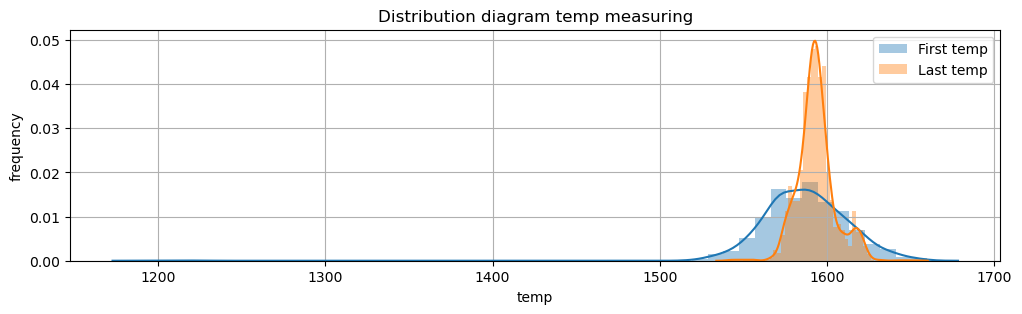

In [80]:
plt.figure(figsize=(12, 3))
sns.distplot(data_sum.first_temp, kde=True, label= 'First temp')
sns.distplot(data_sum.last_temp, kde=True, label= 'Last temp')
plt.grid()
    
plt.title(label=f'Distribution diagram temp measuring')
plt.xlabel('temp')
plt.ylabel('frequency')
plt.legend(loc='upper right')
plt.show()  

<Axes: >

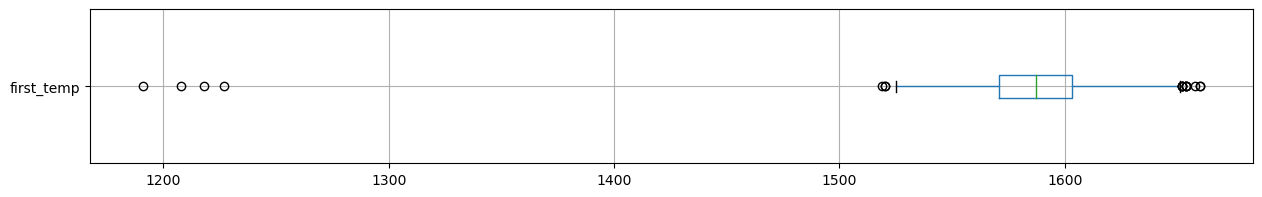

In [81]:
data_sum.boxplot(column=['first_temp'], vert=False, figsize=(15,2))

<Axes: >

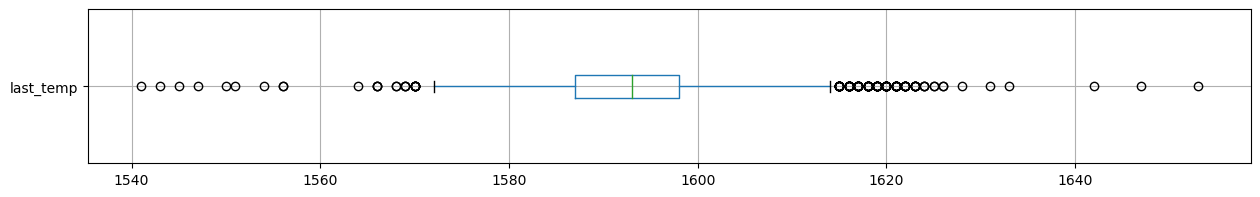

In [82]:
data_sum.boxplot(column=['last_temp'], vert=False, figsize=(15,2))

Определим границы нормальных значений температуры.

In [83]:
norma_temp_down = data_sum.first_temp.describe()[4] - 1.5*(data_sum.first_temp.describe()[6] - data_sum.first_temp.describe()[4])
norma_temp_down

1523.0

In [84]:
norma_temp_up = data_sum.first_temp.describe()[6] + 1.5*(data_sum.first_temp.describe()[6] - data_sum.first_temp.describe()[4])
norma_temp_up

1651.0

Диаграмма размаха и диаграмма распределения начальных и конечных температур показывают, что в выборках по-прежнему имеются выбросы (выделенные в отдельные фракции) за пределами нормальных значений,но их колличество по отношению к значениям в нормальных пределах невелико и они могут быть вполне рабочими

In [85]:
data_sum.shape

(2205, 30)

Оъединение таблиц технологических параметров с учетом хронологии процесса обработки металла и наличия данных о конкретном виде параметра привело к тому, что из более чем 3000 партий осталась информация только 2205 уникальных партиях металла. Потери данных существенны, однако они отражают только реальные хронологически выдержанные процессы с полным объемом доступных параметров.

## Вывод

В ходе предобработки (с учетом приведения значений времени к нужному типу) был получен список технологических параметров подготовки расплава к разливу, включающий в себя парамеры только тех уникальных партий металла, по которым присутсвует последний по хронологии замер температуры, а последние по хронологии метки времени по добавкам легирующих элементов (сыпучих и проволочных материалов) не являются последней записью о технологическом процессе - то есть это полные данные с учетом наличия всех представленных технологических параметров и завершенности процесса подготовки расплава к разливу. Кроме того, полученная выборка была дополнена признаком вхождения температуры в границы нормальных значений. Таким образом из чуть более 3000 партий, данные о которых имелись в различном сочетаниии во всех таблицах датасета на выходеи осталось технологические данные процесса, сведенные в одну таблицу, лишь о 2205 уникальных партях металла. Потеря данных велика, однако они отражают полные и нормальные значения.

# Построение оптимальной модели прогнозирования 

## Выделение признаков и целевого признака.

В качестве целевого признака в соответствии с поставленной задачей примем температуру конечного замера рассплава.

In [86]:
target = data_sum.last_temp

В качестве признаков (влияющих факторов) предварительно примем все остальные столбцы итоговой таблицы технологических параметров, за исключением уникального ключа партии и времен первого и последнего замеров температуры расплава.

In [87]:
features = data_sum.drop(columns=['key', 'first_measure_time', 'last_measure_time', 'last_temp'], axis=1)

Для исключения высокоррелированных признаков с учетом решаемой задачи регрессии, проверим полученную таблицу признаков на мультиколлинеарность, исключив затем высокоскоррелированные признаки.

Построим тепловую карту коэффициентов корреляции.

<Axes: >

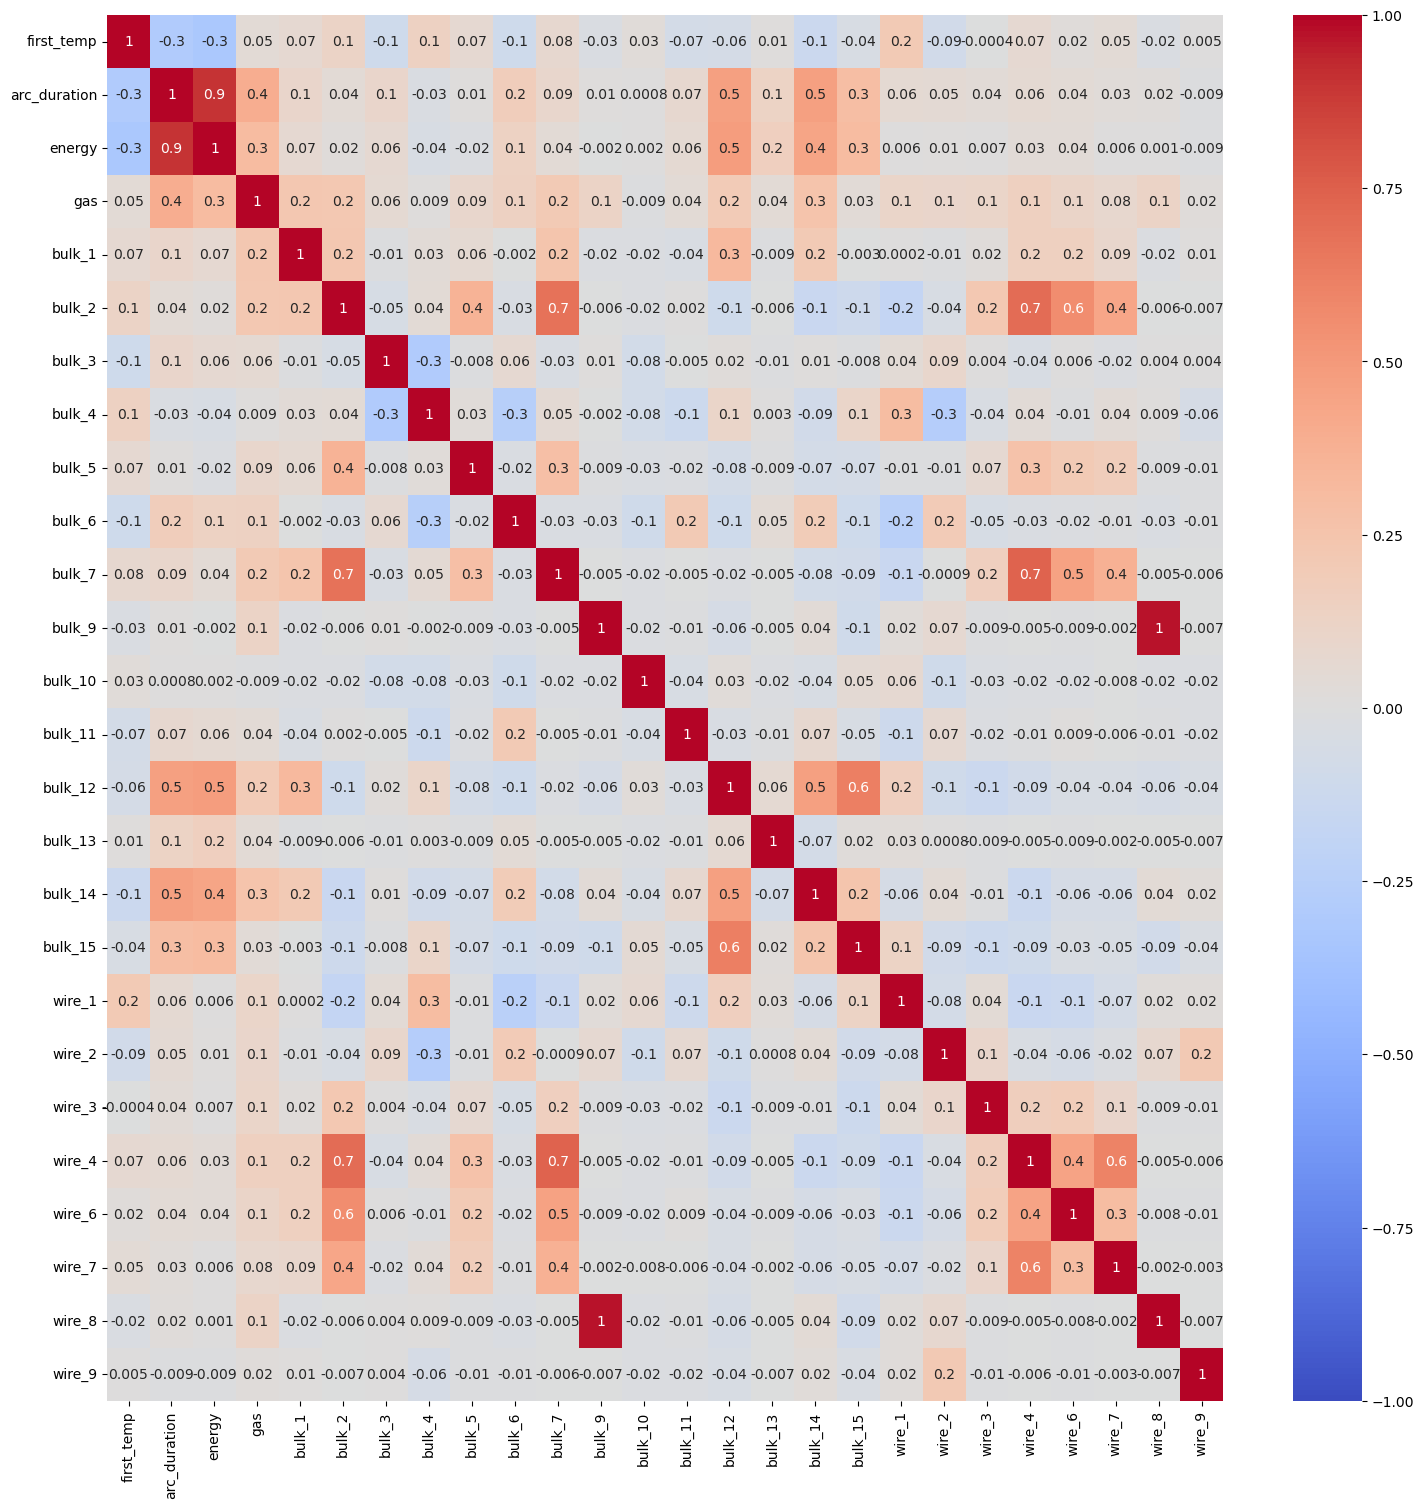

In [88]:
fig, ax = plt.subplots(figsize=(18,18))  
sns.heatmap(features.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

Из полученной карты видно, что признаки wire_8 и bulk_9, energy и arc_duration находятся в прямой зависисимости. Также наблюдается высокий коэффициент корреляции (для прямой зависимости) для признаков bulk_2 и wire_4, bulk_7 и wire_4. Кроме того, в ходе обработки технологических параметров из набора признаков пропали партии металла, при подготовки которых использовалась проволочная добавка wire_7.

In [89]:
features.wire_8.mean()

0.3288178185941043

In [90]:
features.bulk_9.mean()

0.46984126984126984

Исключим из перечня признаков признаки arc_duration и wire_8, а также отсутсвующие данные по wire_7.

In [91]:
features = features.drop(columns=['wire_8', 'arc_duration', 'wire_7'], axis=1)

In [92]:
features.head()

,first_temp,energy,gas,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_9
0,1571.0,0.400660,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0
1,1581.0,0.244787,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0
2,1596.0,0.145852,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0
3,1601.0,0.221364,18.841219,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0
4,1576.0,0.333094,5.413692,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0


## Разделение признаков и целевого признака на обучающую и тестовую выборки.

Проведем разделение признаков на обучающую и тестовую части в соотношении  4/1.

In [93]:
target_train, target_test, features_train, features_test = train_test_split(target, features,
                                                                            test_size=0.2, random_state=12345)

In [94]:
target_train.shape

(1764,)

In [95]:
target_test.shape

(441,)

In [96]:
features_train.shape

(1764, 23)

In [97]:
features_test.shape

(441, 23)

## Стандартизация признаков выборок.

Разброс и масштаб значений признаков достаточно велик, проведем их стандартизацию для равнозначности их применения при построении модели.

In [98]:
scaler = StandardScaler() #вызов преобразователя масштаба и обучение его на тренировочной выборке
scaler.fit(features_train) 

features_train_scaled = scaler.transform(features_train) #стандартизация признаков тренировочной выборки
features_test_scaled = scaler.transform(features_test) #стандартизация признаков тестовой выборки

pd.options.mode.chained_assignment = None

## Информация о метрике оценки качества прогнозирования.

В качестве метрики оценки качества прогнозирования согласована **MAE** - средняя абсолютная ошибка, что дает четкое предтавление об размерности ошибки при выполнения прогноза.

## Выбор наилучшей модели прогнозирования с учетом подбора гипперпараметров.

### Оценка модели линейной регресии

In [99]:
mae_lr = cross_val_score(LinearRegression(), features_train_scaled, target_train, 
                         scoring='neg_mean_absolute_error', cv=10).mean()
print('LinearRegression: MAE =', mae_lr)

LinearRegression: MAE = -6.637961402278302


### Оценка модели решающего дерева

In [100]:
#проверка решающего дерева 
best_mae_dt = -1000
best_depht_dt = 0
for depth in range(1, 50):
    mae_dt = cross_val_score(DecisionTreeRegressor(random_state=12345, max_depth=depth),
                             features_train_scaled, target_train, scoring='neg_mean_absolute_error', cv=10).mean()
    if mae_dt > best_mae_dt:
        best_mae_dt = mae_dt
        best_depht_dt = depth
print('DecisionTreeRegressor: MAE=', best_mae_dt, '; best_depth=', best_depht_dt)

DecisionTreeRegressor: MAE= -7.011865790528103 ; best_depth= 5


### Оценка модели случайного леса

In [101]:
param_grid = {'n_estimators': range(10, 151, 10), 'max_depth': range(5, 51, 5)}

model_rf = RandomForestRegressor(random_state=12345)
grid_rf = GridSearchCV(model_rf, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_rf.fit(features_train_scaled, target_train)

print(grid_rf.best_params_)
print(grid_rf.cv_results_['mean_test_score'].mean())

{'max_depth': 10, 'n_estimators': 60}
-6.2299060100744645


### Оценка модели градиентного бустинга (LGBM)

In [102]:
param_grid = {'n_estimators': [50, 100, 150],
              'max_depth': range(5, 51, 5),
              'learning_rate': [0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]}

model_lgbm = LGBMRegressor(random_state=12345)
grid_lgbm = GridSearchCV(model_lgbm, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_lgbm.fit(features_train_scaled, target_train)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.389086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.389086
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.372785
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data poi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.372785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.372785
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.372785
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.389086
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wis

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.401134
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.401134
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.389086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.372785
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.389086
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.389086
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 1411, 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.401134
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.401134
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.401134
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.372785
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.401134
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.389086
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_le

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth >

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.372785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.372785
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.389086
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.401134
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.401134
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.372785
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data poi

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.372785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explici

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.401134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth >

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.372785
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.401134
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.372785
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wis

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.372785
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.401134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data poi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.401134
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.372785
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (n

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 17
[LightGBM] [Info] Start training from score 1593.423513
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 17
[LightGBM] [Info] Start training from score 1593.363572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': [0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
                                           0.1],
                         'max_depth': range(5, 51, 5),
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_absolute_error')

In [103]:
print(grid_lgbm.best_params_)
print(grid_lgbm.cv_results_['mean_test_score'].mean())

{'learning_rate': 0.07, 'max_depth': 10, 'n_estimators': 50}
-6.200412376861455


### Итоговая модель прогнозирования

Наилучшей моделью по значению метрики MAE с учетом подбора оптимальных гиперпараметров является модель градиентного бустинга LGBM.

Итоговая модель прогнозирования будет выглядеть следующим образом: 

In [104]:
best_model = LGBMRegressor(random_state=12345, max_depth=10, n_estimators=50, learning_rate=0.07)

In [105]:
best_model.fit(features_train_scaled, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1973
[LightGBM] [Info] Number of data points in the train set: 1764, number of used features: 17
[LightGBM] [Info] Start training from score 1593.390023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

LGBMRegressor(learning_rate=0.07, max_depth=10, n_estimators=50,
              random_state=12345)

Построим диаграммы значимости признаков при обучении.

In [106]:
def importances(model):   #функция определеия метрики важности признаков и построения столбчатого графика их значений 
    importances = model.feature_importances_
    pd_importances = pd.Series(importances, features_train.columns).sort_values(ascending=False)
    plt.figure(figsize=(15, 3))
    pd_importances.plot.bar()
    plt.title(label='Feature importances')
    plt.ylabel('Mean decrease in impurity')
    plt.grid(axis='y')
    plt.show()

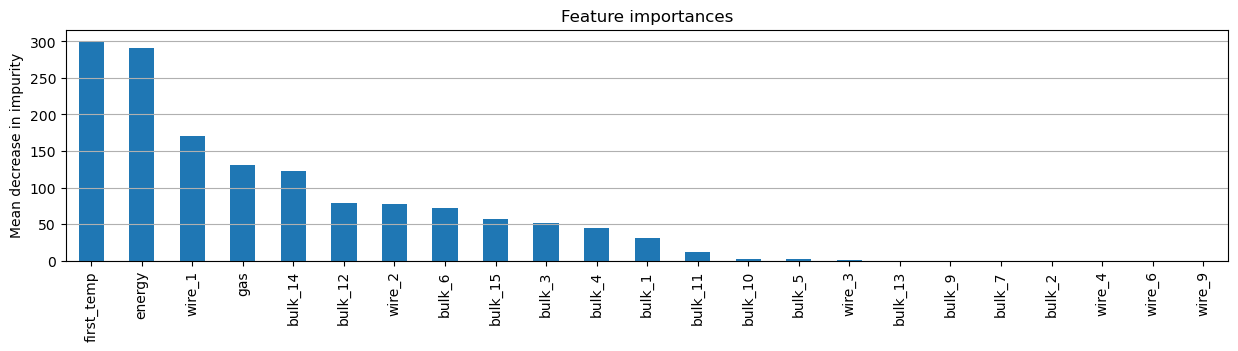

In [107]:
importances(best_model)

Как видно из полученной дмаграммы наиболее важным признаком для прогнозирования температуры расплава полученной моделью является первичное значение температуры расплава, а также электроэнергия переданная металлу, далее идет проволочная добавка wire_1, объемы продувки газом и прочие сыпучие и проволочные добавки. А в целом из полученного изначально перечня из 23 признаков для прогнозирования, фактически важными оказались лишь примерно 13.

###  Проверка полученной модели на тестовом наборе данных

Проведем проверку полученной наилучшей модели на тестовом наборе данных.

In [108]:
target_test_pred = best_model.predict(features_test_scaled)
mae_test = mean_absolute_error(target_test, target_test_pred)
print(mae_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6.254715307667275


Полученная метрика весьма низкая, что говорит о достаточно высоком качестве моделей.

### Проверка полученной модели на адекватность

Для оценки адекватности полученной модели проведем ее проверку с предсказаниями константной модели - фиктивного регрессора составляющего прогнозы на основе медианы тренировочной выборки. Скравним значение MAE константной модели и наилучшей полученной модели.

In [109]:
# обучение модели DummyRegressor по стратегии медианы на тестовом наборе для этапа флотации и получение sMAPE
dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(features_train_scaled, target_train)
dummy_pred = dummy_regressor.predict(features_test_scaled)
mae_dummy = mean_absolute_error(target_test, dummy_pred)
print(mae_dummy)

8.2368046235879


Прогноз константной модели оказался хуже прогноза лучшей модели, ее метрика MAE значительно выше. Модель можно признать адекватной.

## Вывод

В ходе построения оптимальной модели прогонозирования были пройдены следующие этапы:
   - Выделены признаки и целевой признак, уменьшена выборка для нормализации данных;
   - Проведено разделение данных на тестовую и обучающую выборки в соотношении 1/4 соответсвенно;
   - Проведена стандартизации признаков выборок;
   - Обозначена метрика оценки качества прогнозирования моделей.
   - Осуществлен выбор оптимальной модели прогнозирования и настройка ее гиперпараметров. В качестве моделей рассматривались линейная регрессия, "решающее дерево", "случайный лес", градиентныей бустинг на базе LGBM. Наилучшем качеством прогноза обладает модель градиентныей бустинг на базе LGBM (с учетом настроенных гипперпараметров: 'learning_rate': 0.07, 'max_depth': 10, 'n_estimators': 50}.
   - Проведена проверка полученной наилучшей модели на тестовом наборе данных.
   - Проведена проверка модели на адекватность.
   
   Полученная модель адекватна, обладает достаточным качеством прогнозирования при MAE < 6.5.



# Отчет о выполненной работе

В ходе уточнения параметров технологического процесса и конечных целей поставленная задача была сформулирована как построение оптимальной регрессионной модели машинного обучения для определения конечной температуры раплава металла перед разливом. Метрикой качества избрана MAE (средняя абсолютная ошибка). 
Модель должна способствовать уменьшению энергозатрат на этапе поготовки металла к разливу.

Так как целевым признаком была объявлена температура на последнем замере, из предоставленных данных были отобраны только те партии металла, по которым данные о подобном замере присутсвуют в датасете. Кроме того, с учетом меток времени из датасета была исключена информации о технологических параметрах по тем партиям, которым в исследуемм объеме даных являются незавершенными, то есть информация по другим технологическим операциям которых была получена позже, чем произведен последний замер температуры.

В датасете в большом объеме присутствовали пропуски по отдельным видам данных - объемы сыпучих и проволочных добавок легирующих материалов, отднако с учетом информации о времени ввода добавок пропуски были заполнены нулевыми значениями, так как было установлено, что согласно меткам времени конкретные добавки в отдельные моменты не вводились.

С учетом заполнения пропусков и получения значений конечного замера температур, приведения значений периодов нагрева и величин мощностей нагрева к электроэнергии, была получена сводная таблица о технологических параметрах с уникальными ключами только тех партий, по которым есть поледний замер температур, а вся остальная информация присутсвует в полном объеме. Потеря данных была существенна, однако она позволила добиться их высокой чистоты для более качественного процесса обучения модели

После завершения этапа обработки и  сведения технологической информации, для построения оптимальной модели прогнозирования были выделены целевой признак и факторы прогнозирования, в состав которых были включены: данные о первичном замере температуре, переданной расплаву электроэнергии, значения объемов сыпучих и проволочных добавок легирующих материалов, объемы продувки расплава газом, суммарное время

При иследовании факторов на мультиколлинеарность были отсеяны несколько параметров имеющих высокий коэффициент корреляции с другими признаками (исключены 'wire_8', 'arc_duration', 'wire_7').

Поученные значения целевого признака и факторов прогнозирования были разделены на обучающую и тестовую выборки в соотношении 4/1 соответственно.

Для постоения оптимальной модели прогноза были исследованы несколько стандартных моделей машинного обучения: линейная регрессия, "решающее дерево", "случайный лес" и модель градиентного бустинга на базе LGBM.

С учетом оптимизации гиперпараметров лучшей по значению выбранной метрики модель модель градиентного бустинга на базе LGBM c колличеством "решающих деревьев": 50 и глубиной 10 и скоростью обучения 0.07.

Исследование важности признаков прогнозирования в отимизированной модели указывает на то, что для последующего прогнозиорваня можон сключить часть иформаци о вводе в рассплав отдельых легирующх добавок (как сыпучих, так и проволочнвх материалов), сократив набор признаков почти вдвое.

Дальнейшее проверка полученной оптимальной модели на тестоой выборке и проверка ее на адекватность в сравнении с моделью фиктивного регрессора доказывает ее эффективность и возможность использования в процессах оптимизации технологической цепочки.
Итоговая MAE = 6.20

Цель достигнута.